# Test1: classify galaxies with SimCLR trained with CIPAR10

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.transforms import transforms
#from torchvision import models

import atm
import atm.simclr as simclr
import atm.simclr.resnet as models

import argparse 

In [1]:
do_parallel = True

args = argparse.Namespace()

args.data='./datasets' 
#args.dataset_name='cifar10'
args.arch='resnet50'
args.n_channels=1
args.workers=1
args.epochs=300 

if do_parallel:
    args.batch_size = 128
else:
    args.batch_size = 256

args.lr=0.02
args.weight_decay=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=128
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
#args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'

print("Using args.device:", args.device)

img_size =128


assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    #args.gpu_index = -1

Using args.device: cuda


In [ ]:
from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.vision import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]
    
class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap, weight = self._array[idx]['data']
        image[~_segmap.astype(bool)] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        target = self.img_labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return image, target

    
class ContrastiveLearningDataset():
    def __init__(self):
        pass
    
    @staticmethod
    def get_simclr_pipeline_transform(size, s=1, n_channels=3):
        """Return a set of data augmentation transformations as described in the SimCLR paper.
            Only works if input image is originally 3-channel.
        """
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * size)),
                                              transforms.ToTensor()])
        if n_channels == 1:
            _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]
            
        return data_transforms

    def get_dataset(self, name, n_views, n_channels=3):
        return TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                labels=cat['TT'].to_numpy(),
                                train=True, 
                                transform=ContrastiveLearningViewGenerator(
                                    self.get_simclr_pipeline_transform(img_size, n_channels=1)
                                ))

In [2]:
import pickle

ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim, num_channels=1),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim, num_channels=1)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)


import logging
import os
import sys
import yaml

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
#from utils import save_config_file, accuracy, save_checkpoint



def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def get_simclr_pipeline_transform(size, s=1, n_channels=3):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    _transforms = [transforms.RandomResizedCrop(size=size),
                  #GaussianBlur(kernel_size=int(0.1 * size)),
                  transforms.ToTensor()]
    if n_channels == 1:
        _transforms = _transforms + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]

    return transforms.Compose(_transforms)

In [6]:
checkpoint = torch.load('./runs/Sep27_14-37-09_hoseung-kasi/checkpoint_0300.pth.tar',
                        map_location=args.args.device) # 이건 ResNet을 돌린 건듯. 
state_dict = checkpoint['state_dict']
model = ResNetSimCLR(base_model=args.arch, out_dim=10)
log = model.load_state_dict(state_dict, strict=False)

In [3]:
def view_checkpoint_summary(chk):
    for key, val in chk.items():
        if key in ['state_dict', 'optimizer']:
            continue
        print(key, val)

In [5]:
# Load and check saved model
checkpoint = torch.load('/home/hoseung/Dropbox/temp/runs/20210929-192413_cifar10_resnet50_1_256/checkpoint_0200.pth.tar',
                        map_location=args.device)


view_checkpoint_summary(checkpoint)

state_dict = checkpoint['state_dict']

#print(state_dict.keys())

# remove the prefix 'backbone.'
for k in list(state_dict.keys()):
    if k.startswith('backbone.'):
        if k.startswith('backbone') and not k.startswith('backbone.fc'):
            # remove prefix
            state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]

#state_dict.keys()

epoch 200
arch resnet50
dataset cifar10
batchsize 256


In [7]:
model = models.resnet50(pretrained=False, num_classes=10, num_channels=1)
##ResNetSimCLR(base_model=args.arch, out_dim=10) # 만들고자하는 모델은 일반적인 ResNet이므로 output이 10.
    
log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ["fc.weight", "fc.bias"]
#model.to(args.args.device)

print(log)
model = model.to(args.device)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])


### Visualize trained feature vectors

### Test with CIFAR10 first

In [9]:
from tqdm import tqdm
from torch.cuda.amp import autocast
import torchvision
from torchvision import transforms

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


## What does embeddings look like??

In [ ]:
model.fc = nn.Identity()

feature_arr = []
label_arr = []
for images, l in tqdm(testloader):
    images = images.to(args.args.device)

    # autocast <- AMP
    with autocast(enabled=args.fp16_precision):
        features = model(images)
        
    feature_arr.append(features.cpu().detach().numpy())
    label_arr.append(l)

feature_arr = np.concatenate(feature_arr)
label_arr = np.concatenate(label_arr)

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 1.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.791196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.445541
[t-SNE] KL divergence after 1000 iterations: 1.660947


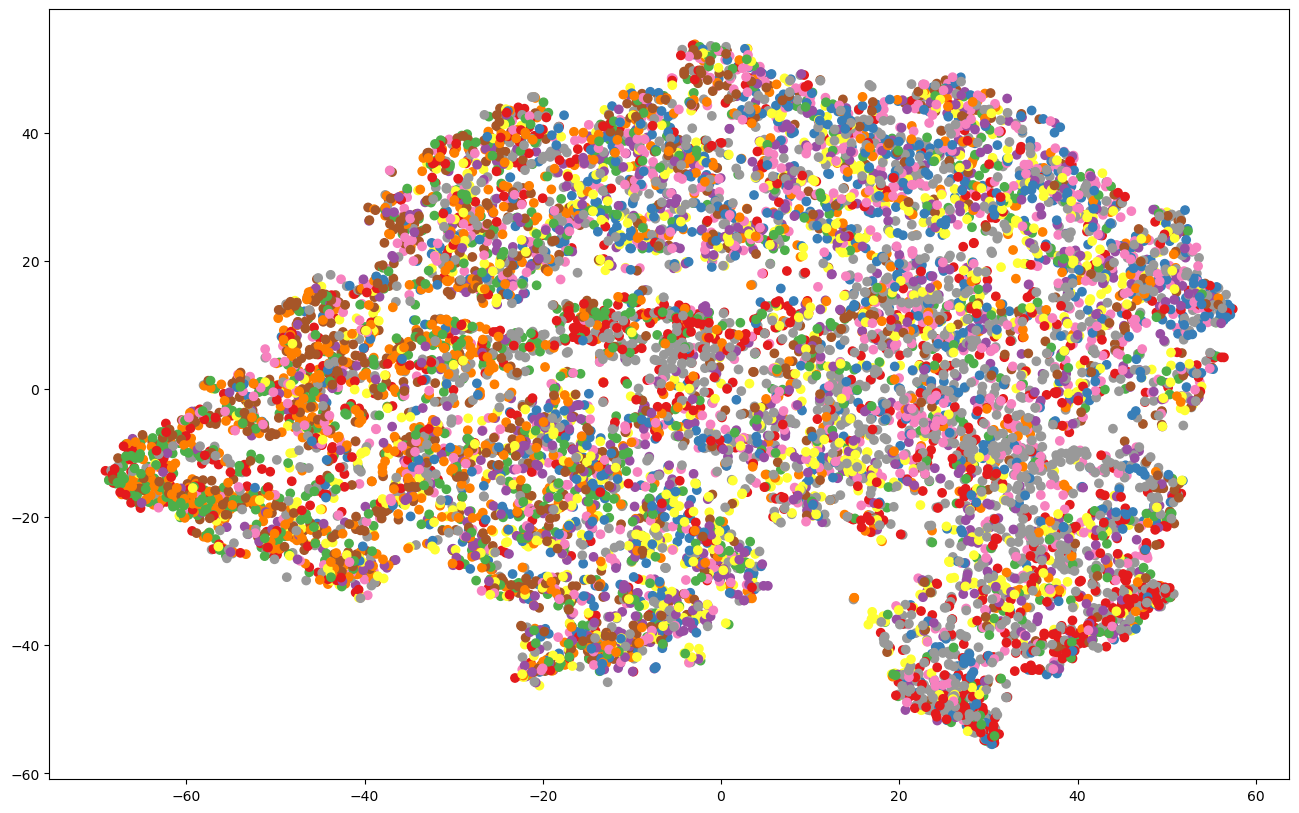

In [33]:
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE

perp = 75
n_iter = 1000
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=n_iter)
# n_components : the number of reduced dimension.
# perplexity : (roughly) number of neighbors.
tsne_results = tsne.fit_transform(feature_arr)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_arr, cmap='Set1')
plt.savefig(f"1ch_stl_400epochs_perp{perp}_iter{n_iter}.png")
plt.show()

## Linear classifier trained on SimCLR embeddings

-- Freeze all layers except the last FC

In [34]:
bare = True

if bare:
    # Bare R18_ch1
    fn_pth = '/home/hoseung/Dropbox/temp/runs/20210930-025624_cifar10_resnet18_1_256/Resnet_ch1_cifar10_bn256_200_199.pth'
else:
    # SimCLR_R50_ch1 
    fn_pth = '/home/hoseung/Dropbox/temp/runs/20210929-192413_cifar10_resnet50_1_256/checkpoint_0200.pth.tar'


checkpoint = torch.load(fn_pth, map_location=args.device)

view_checkpoint_summary(checkpoint)

state_dict = checkpoint['state_dict']

model = models.resnet50(pretrained=False, num_classes=10, num_channels=1)
##ResNetSimCLR(base_model=args.arch, out_dim=10) # 만들고자하는 모델은 일반적인 ResNet이므로 output이 10.
    
log = model.load_state_dict(state_dict, strict=False)

print(log)

if not bare: assert log.missing_keys == ["fc.weight", "fc.bias"]
model = model.to(args.device)

epoch 200
<All keys matched successfully>


In [35]:
# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(args.device)

### Train a 'linear' classifier

In [36]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [37]:
dataset_name = "cifar10"

from torchvision import datasets

def get_stl10_data_loaders(download, n_channel=3, batch_size=256):
    _transform = [transforms.ToTensor()]
    if n_channel == 1:
        _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]
    train_dataset = datasets.STL10('./data', split='train', download=download,
                                  transform=transforms.Compose(_transform))

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=10, drop_last=False, shuffle=True)

    test_dataset = datasets.STL10('./data', split='test', download=download,
                                  transform=transforms.Compose(_transform))

    test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=False)
    return train_loader, test_loader

def get_cifar10_data_loaders(download, n_channel=3, shuffle=False, batch_size=256):
    _transform = [transforms.ToTensor()]
    if n_channel == 1:
        _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]
    train_dataset = datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.Compose(_transform))

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=10, drop_last=False, shuffle=True)

    test_dataset = datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.Compose(_transform))

    test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=False)
    return train_loader, test_loader

In [38]:
if dataset_name == "galaxy":
    train_dataset = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                        labels=cat['TT'].to_numpy(),
                                        train=True, 
                                        transform=get_simclr_pipeline_transform(128, n_channels=args.n_channels)
                                        )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True, drop_last=True)
    
    test_dataset = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                        labels=cat['TT'].to_numpy(),
                                        train=False, 
                                        transform=get_simclr_pipeline_transform(128, n_channels=args.n_channels)
                                        )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True, drop_last=True)
elif dataset_name == "cifar10":
    train_loader, test_loader = get_cifar10_data_loaders(download=True, n_channel=args.n_channels)
elif dataset_name == "stl10":
    train_loader, test_loader = get_stl10_data_loaders(download=True, n_channel=args.n_channels)

print("test dataset:", dataset_name)

Files already downloaded and verified
Files already downloaded and verified
test dataset: cifar10


In [40]:
writer.log_dir

'20210930-040301_cifar10_resnet50_1_transfer'

In [39]:
import time
from torch.utils.tensorboard import SummaryWriter

n_channels=1
device = args.device

timestr = time.strftime("%Y%m%d-%H%M%S")
log_dir = timestr + f"_{dataset_name}_{args.arch}_{args.n_channels}_transfer"
writer = SummaryWriter(log_dir=log_dir)

epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)

    # write everystep
    writer.add_scalar('loss', loss, global_step=epoch)
    writer.add_scalar('acc/top1', top1_accuracy, global_step=epoch)
    writer.add_scalar('acc/top5', top5_accuracy, global_step=epoch)
    #writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}"
            f"\tTop1 Test accuracy: {top1_accuracy.item()}"
            f"\tTop5 test acc: {top5_accuracy.item()}")
    
    
## Bare Resnet-18의 결과

Epoch 0	Top1 Train accuracy 48.38169479370117	Top1 Test accuracy: 47.311580657958984	Top5 test acc: 84.46691131591797
Epoch 1	Top1 Train accuracy 50.68159866333008	Top1 Test accuracy: 48.75230026245117	Top5 test acc: 85.02240753173828
Epoch 2	Top1 Train accuracy 51.85825729370117	Top1 Test accuracy: 49.636375427246094	Top5 test acc: 85.56583404541016
Epoch 3	Top1 Train accuracy 52.43981170654297	Top1 Test accuracy: 50.105125427246094	Top5 test acc: 85.88924407958984
Epoch 4	Top1 Train accuracy 52.741947174072266	Top1 Test accuracy: 50.36017990112305	Top5 test acc: 86.35857391357422
Epoch 5	Top1 Train accuracy 52.98270034790039	Top1 Test accuracy: 50.52619552612305	Top5 test acc: 86.7308120727539
Epoch 6	Top1 Train accuracy 53.14413070678711	Top1 Test accuracy: 50.703125	Top5 test acc: 86.77102661132812
Epoch 7	Top1 Train accuracy 53.145328521728516	Top1 Test accuracy: 50.78125	Top5 test acc: 87.00655364990234
Epoch 8	Top1 Train accuracy 53.39086151123047	Top1 Test accuracy: 50.8984375	

In [26]:
# Resnet SimCLR ch1 결과

/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0	Top1 Train accuracy 17.649473190307617	Top1 Test accuracy: 19.801816940307617	Top5 test acc: 71.30170440673828
Epoch 1	Top1 Train accuracy 20.879703521728516	Top1 Test accuracy: 21.668773651123047	Top5 test acc: 72.62752532958984
Epoch 2	Top1 Train accuracy 22.085060119628906	Top1 Test accuracy: 22.26332664489746	Top5 test acc: 72.94979095458984
Epoch 3	Top1 Train accuracy 22.220184326171875	Top1 Test accuracy: 22.674633026123047	Top5 test acc: 73.21117401123047
Epoch 4	Top1 Train accuracy 22.495216369628906	Top1 Test accuracy: 23.07042694091797	Top5 test acc: 73.41625213623047
Epoch 5	Top1 Train accuracy 22.480070114135742	Top1 Test accuracy: 23.44898796081543	Top5 test acc: 73.35880279541016
Epoch 6	Top1 Train accuracy 22.643892288208008	Top1 Test accuracy: 23.49781608581543	Top5 test acc: 73.60179901123047
Epoch 7	Top1 Train accuracy 22.80731773376465	Top1 Test accuracy: 23.528263092041016	Top5 test acc: 73.48345184326172
Epoch 8	Top1 Train accuracy 22.678173065185547	Top1 T

Exception ignored in: <function _releaseLock at 0x7f1916d40310>
Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process Process-1938:
Exception ignored in: <function _releaseLock at 0x7f1916d40310>
Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/multiprocessing/process.py", line 308, in _bootstrap
    util._run_after_forkers()
KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 990, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/multiprocessing/queues.py", line 107, in get
    if not self._poll(timeout):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/utils/data/_utils/si

TypeError: object of type 'NoneType' has no len()

In [ ]:
writer.close()

ㅋㅋㅋ 뭔가 웃긴게 나옴. (galaxy -> cifar10 결과) 

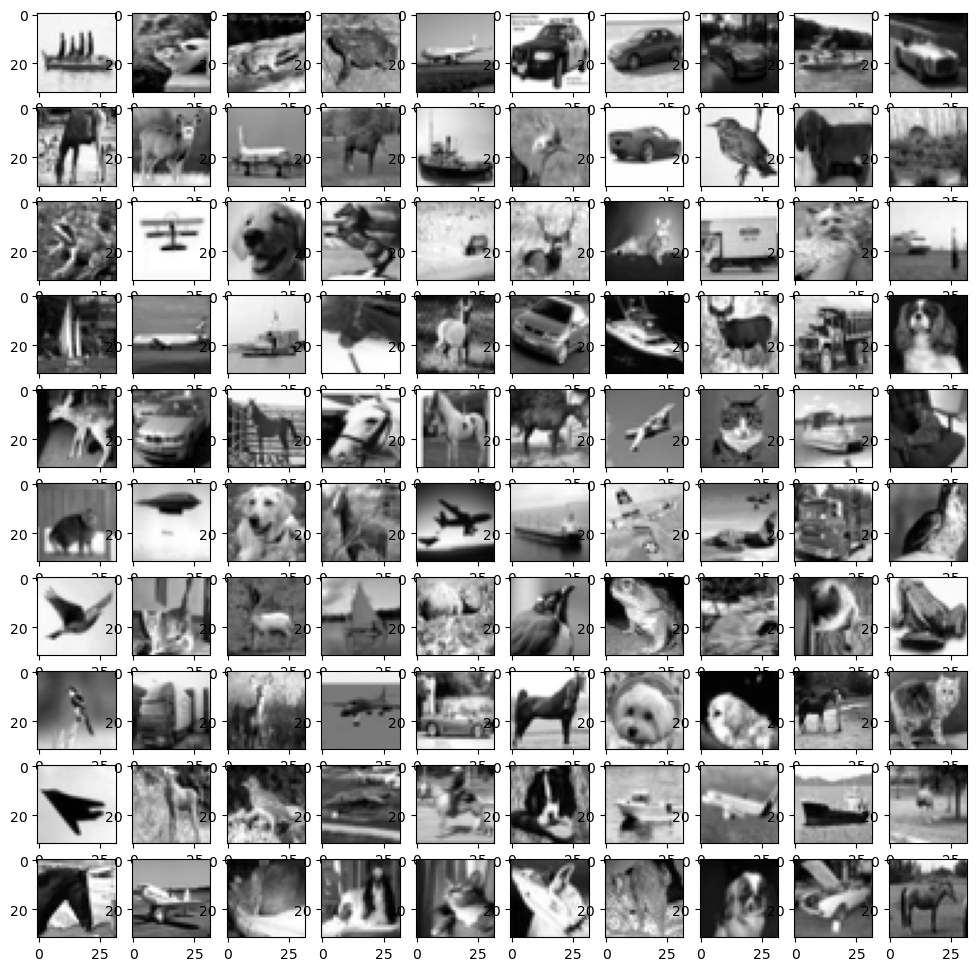

In [63]:
fig, axs = plt.subplots(10,10, figsize=(12,12))

axs = axs.ravel()

for ax, img in zip(axs, images):
    img = img.squeeze(0).to('cpu')
    ax.imshow(img, cmap='gray')
    
plt.show()

OK, channel-averaged images all look reasonable!

What about feature vectors? 
1. Do feature vectors of the same/different classes look similar/different?
2. What's the expected range of feature vector values? 
3. How does averagaed feature vector of each class compare? -- draw ridge plots

## Test with Galaxy Images next